In [1]:
#Run Imports each time
import os, json, ast, csv, shutil, synapseclient
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from dateutil import parser
from scipy.signal import butter, lfilter, freqz
from myconfig import *

%matplotlib inline

#these 2 are unused
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
startTimeparse = lambda x: parser.parse(x)

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def getSynapseData(syn,
            data_dir='.', 
            projectId="syn3270434",
            tables = ["AboutYou", 'NonIdentifiableDemographicsTask', 'EQ_5D']):
    """
    Logs you into Synapse and gets tables from the Asthma Project
    """
    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    table_query = syn.query("SELECT id, name FROM table WHERE parentId=='%s'" % projectId)

    for result in table_query['results']:
        # fragile - may break if new tables are name
        if "metadata" not in result['table.name']:
            name = result['table.name'].split('-')[1]
            if name in tables:
                print name
                response = syn.tableQuery("SELECT * FROM %s" % result['table.id'] )
                shutil.move(response.filepath, join(data_dir, '%s.csv' % name))
                print
                
def loadAndJoinData(data_dir='test_data'):
    """
    Loads downloaded data and joins on healthCode
    """
    d = {} # all data
    for fn in os.listdir(data_dir):
        if fn[0]==".":
            continue
        print fn
        with open(os.path.join(data_dir,fn)) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['healthCode'] in d:
                    if fn in d[row['healthCode']]:
                        d[row['healthCode']][fn].append(row) 
                    else:
                        d[row['healthCode']][fn] = [row]
                else:
                    d[row['healthCode']]={}
                    d[row['healthCode']][fn] = [row]
    return d

def DownloadTableColumns(syn, table_id = 'syn4927133', columns = [(-2, "other_feedback"), ], 
                  base_path = "/Users/hershman/Desktop", limit=50, table_fn = "table.csv"):
    """Does a lot
            Downloads data from column of index in table_id
            Puts it in base_path/column
            Summarizes output to screen or a file named out
            
        EDIT:S Downloads latest table and has limit
    """
    
    #make subdirs
    for _, column in columns: 
        if not os.path.exists("%s/%s/" % (base_path, column)):
            os.mkdir("%s/%s/" % (base_path, column))
    
    schema = syn.get(table_id)
    results = syn.tableQuery('select * from %s ORDER BY "uploadDate" DESC' % table_id, resultsAs="rowset")
    rows_list = []
    table_columns = [x['name'] for x in results.headers]
    
    for i, row in enumerate(results):
        #print row.rowId, row.versionNumber, row.values
        try:
            for index, column in columns:
                data_col = row['values'][index]
                if data_col:
                    if not os.path.exists("%s/%s/%s" % (base_path, column, data_col)):
                        old_fn = syn.downloadTableFile(schema,
                                              rowId=row.rowId,
                                              versionNumber=row.versionNumber, 
                                              column=column,
                                              downloadLocation='.',
                                              ifcollision="keep.local")

                        new_fn = "%s/%s/%s" % (base_path, column, data_col)
                        #print old_fn['path']
                        os.rename(old_fn['path'],  new_fn)
                        #print old_fn, new_fn
                else:
                    pass
                    #print "No data", row.rowId, row.versionNumber, row.values
                    


        except:
            print "there was an exception..."
        dict1 = dict(zip(table_columns, row.items()[1][1]))
        rows_list.append(dict1)  
            
        if i == limit:
            print "Ending at limit %d" % limit
            break
            
            
    df = pd.DataFrame(rows_list)
    df.to_csv(os.path.join(base_path, table_fn), index = False, columns = table_columns)
    return df

In [2]:
syn = synapseclient.Synapse()
syn.login(USER, PASSWORD)

Welcome,  !




UPGRADE AVAILABLE

A more recent version of the Synapse Client (1.7.2) is available. Your version (1.6.2) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 1.7.2 release notes

https://github.com/Sage-Bionetworks/synapsePythonClient/blob/master/release_notes/release-1.7.1.md



In [164]:
#now optional
getSynapseData(syn,
            data_dir='data/MHC', 
            projectId="syn3270436",
            tables = ["6", "6MWT Displacement Data" ])

6MWT Displacement Data

6



In [6]:
#6 - healthKit and acceleromter data

columns = ( (10, "pedometer_fitness.walk.items"), 
            (11, 'accel_fitness_walk.json.items'),
            (12, 'deviceMotion_fitness.walk.items'),
            (13, 'HKQuantityTypeIdentifierHeartRate_fitness.walk.items'),
            (14, 'accel_fitness_rest.json.items'),
            (15, 'deviceMotion_fitness.rest.items'),
            (16, 'HKQuantityTypeIdentifierHeartRate_fitness.rest.items'))
base_path="/Users/hershman/Amazon Drive/Stanford/data/MHC/6mwt"
table_fn = "6mwt.csv"

df = DownloadTableColumns(syn, table_id = 'syn4857044', columns = columns, 
              base_path=base_path, table_fn = table_fn)

Ending at limit 50


In [4]:
df = pd.read_csv(join(base_path, table_fn))


In [5]:
test_row = df.iloc[0]

In [7]:
data_columns = ["accel_fitness_walk.json.items", "deviceMotion_fitness.walk.items", \
                "accel_fitness_rest.json.items", "deviceMotion_fitness.rest.items", "pedometer_fitness.walk.items"]

In [141]:
data_column = data_columns[1]
data_column

'deviceMotion_fitness.walk.items'

In [56]:
#"pedometer_fitness.walk.items" (HealthKit data) appears cumulative
data_column = data_columns[4]
data_fn = '%s/%s/%d' % (base_path, data_column, test_row[data_column])


ped_df = pd.read_json(data_fn)
# Parse dates
ped_df['startDate']=pd.to_datetime(ped_df['startDate'])
ped_df['endDate']=pd.to_datetime(ped_df['endDate'])
ped_df
ped_df

,distance,endDate,floorsAscended,floorsDescended,numberOfSteps,startDate
0,10.010000,2017-07-11 05:01:54,0,0,13,2017-07-11 05:01:47
1,13.810000,2017-07-11 05:01:57,0,0,18,2017-07-11 05:01:47
2,18.550000,2017-07-11 05:02:00,0,0,24,2017-07-11 05:01:47
3,21.525186,2017-07-11 05:02:02,0,0,29,2017-07-11 05:01:47
4,23.997150,2017-07-11 05:02:05,0,0,35,2017-07-11 05:01:47
5,25.299830,2017-07-11 05:02:07,0,0,41,2017-07-11 05:01:47
6,27.128974,2017-07-11 05:02:10,0,0,46,2017-07-11 05:01:47
7,31.056163,2017-07-11 05:02:13,0,0,52,2017-07-11 05:01:47
8,31.856825,2017-07-11 05:02:15,0,0,57,2017-07-11 05:01:47
9,34.702559,2017-07-11 05:02:18,0,0,63,2017-07-11 05:01:47


In [208]:
ped_df.endDate-ped_df.startDate

0    00:00:07
1    00:00:10
2    00:00:13
3    00:00:15
4    00:00:18
5    00:00:20
6    00:00:23
7    00:00:26
8    00:00:28
9    00:00:31
10   00:00:33
11   00:00:36
12   00:00:39
13   00:00:41
14   00:00:44
...
121   00:05:20
122   00:05:23
123   00:05:25
124   00:05:28
125   00:05:31
126   00:05:33
127   00:05:36
128   00:05:38
129   00:05:41
130   00:05:44
131   00:05:46
132   00:05:49
133   00:05:51
134   00:05:54
135   00:05:57
Length: 136, dtype: timedelta64[ns]

In [228]:
data_column = data_columns[1]
data_fn = '%s/%s/%d' % (base_path, data_column, test_row[data_column])
dm_df = pd.read_json(data_fn)

In [238]:
dm_df.shape

(35617, 6)

In [237]:
dm_df.timestamp.max()-dm_df.timestamp.min()

359.69791495834943

In [229]:
dm_df['timestamp'].apply(lambda x: x/60/60/24) 
#days since iphone was started

0     2.205063
1     2.205063
2     2.205063
3     2.205063
4     2.205063
5     2.205063
6     2.205063
7     2.205063
8     2.205063
9     2.205064
10    2.205064
11    2.205064
12    2.205064
13    2.205064
14    2.205064
...
35602    2.209224
35603    2.209224
35604    2.209224
35605    2.209224
35606    2.209225
35607    2.209225
35608    2.209225
35609    2.209225
35610    2.209225
35611    2.209225
35612    2.209225
35613    2.209225
35614    2.209225
35615    2.209226
35616    2.209226
Name: timestamp, Length: 35617, dtype: float64

In [226]:
dm_df

,attitude,gravity,magneticField,rotationRate,timestamp,userAcceleration
0,"{u'y': 0.0778611657513, u'x': -0.0032365078120...","{u'y': 0.00667789438739, u'x': 0.155239269137,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.224127978086, u'x': 1.12747383118, u...",190517.402260,"{u'y': 0.0941521823406, u'x': -0.1065332219, u..."
1,"{u'y': 0.0769377194549, u'x': 0.00238825658585...","{u'y': -0.00417535984889, u'x': 0.153435990214...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.129586040974, u'x': 1.15111684799, u...",190517.412362,"{u'y': 0.077997379005, u'x': -0.117226883769, ..."
2,"{u'y': 0.0768403318587, u'x': 0.0081553355655,...","{u'y': -0.0152688026428, u'x': 0.153323322535,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0312571711838, u'x': 1.18713402748, u...",190517.422463,"{u'y': 0.057062625885, u'x': -0.13418880105, u..."
3,"{u'y': 0.0772705667863, u'x': 0.0138410525051,...","{u'y': -0.0262797344476, u'x': 0.154294326901,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0959394946694, u'x': 1.13858747482, u...",190517.432564,"{u'y': 0.0580943115056, u'x': -0.0812962800264..."
4,"{u'y': 0.0778204025958, u'x': 0.0191557341433,...","{u'y': -0.0364721603692, u'x': 0.155552536249,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.121438190341, u'x': 1.06629920006, u'...",190517.442666,"{u'y': 0.059619743377, u'x': -0.0769392624497,..."
5,"{u'y': 0.0783459189058, u'x': 0.0239512604872,...","{u'y': -0.045701328665, u'x': 0.156774297357, ...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0911258161068, u'x': 0.946194052696, ...",190517.452767,"{u'y': 0.070039100945, u'x': -0.0611627288163,..."
6,"{u'y': 0.0784804667629, u'x': 0.0281803730087,...","{u'y': -0.0536921173334, u'x': 0.157280102372,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0147032095119, u'x': 0.854720056057, ...",190517.462868,"{u'y': 0.0617640167475, u'x': -0.0585709959269..."
7,"{u'y': 0.0781174997821, u'x': 0.0319591975514,...","{u'y': -0.06084863469, u'x': 0.156810045242, u...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.120897233486, u'x': 0.764785945415, ...",190517.472970,"{u'y': 0.0523952655494, u'x': -0.0655624866486..."
8,"{u'y': 0.0771163122857, u'x': 0.0353012470074,...","{u'y': -0.0670015513897, u'x': 0.155165210366,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.211830079556, u'x': 0.697763741016, ...",190517.483071,"{u'y': 0.0510255992413, u'x': -0.0534959025681..."
9,"{u'y': 0.0760997924854, u'x': 0.0381781882211,...","{u'y': -0.0722615644336, u'x': 0.153502762318,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.209982901812, u'x': 0.596245884895, ...",190517.493172,"{u'y': 0.0401418097317, u'x': -0.0544427074492..."


In [227]:

# dm_df['timestamp']=pd.to_datetime(dm_df['timestamp'])

dm_df['timestamp']=dm_df['timestamp'].apply(lambda x: x*1000000000000)
dm_df['timestamp']=pd.to_datetime(dm_df['timestamp'])
dm_df

,attitude,gravity,magneticField,rotationRate,timestamp,userAcceleration
0,"{u'y': 0.0778611657513, u'x': -0.0032365078120...","{u'y': 0.00667789438739, u'x': 0.155239269137,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.224127978086, u'x': 1.12747383118, u...",1976-01-15 01:30:02.259666688,"{u'y': 0.0941521823406, u'x': -0.1065332219, u..."
1,"{u'y': 0.0769377194549, u'x': 0.00238825658585...","{u'y': -0.00417535984889, u'x': 0.153435990214...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.129586040974, u'x': 1.15111684799, u...",1976-01-15 01:30:12.361666720,"{u'y': 0.077997379005, u'x': -0.117226883769, ..."
2,"{u'y': 0.0768403318587, u'x': 0.0081553355655,...","{u'y': -0.0152688026428, u'x': 0.153323322535,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0312571711838, u'x': 1.18713402748, u...",1976-01-15 01:30:22.462666624,"{u'y': 0.057062625885, u'x': -0.13418880105, u..."
3,"{u'y': 0.0772705667863, u'x': 0.0138410525051,...","{u'y': -0.0262797344476, u'x': 0.154294326901,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0959394946694, u'x': 1.13858747482, u...",1976-01-15 01:30:32.563666688,"{u'y': 0.0580943115056, u'x': -0.0812962800264..."
4,"{u'y': 0.0778204025958, u'x': 0.0191557341433,...","{u'y': -0.0364721603692, u'x': 0.155552536249,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.121438190341, u'x': 1.06629920006, u'...",1976-01-15 01:30:42.665666592,"{u'y': 0.059619743377, u'x': -0.0769392624497,..."
5,"{u'y': 0.0783459189058, u'x': 0.0239512604872,...","{u'y': -0.045701328665, u'x': 0.156774297357, ...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0911258161068, u'x': 0.946194052696, ...",1976-01-15 01:30:52.766666720,"{u'y': 0.070039100945, u'x': -0.0611627288163,..."
6,"{u'y': 0.0784804667629, u'x': 0.0281803730087,...","{u'y': -0.0536921173334, u'x': 0.157280102372,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': 0.0147032095119, u'x': 0.854720056057, ...",1976-01-15 01:31:02.867666688,"{u'y': 0.0617640167475, u'x': -0.0585709959269..."
7,"{u'y': 0.0781174997821, u'x': 0.0319591975514,...","{u'y': -0.06084863469, u'x': 0.156810045242, u...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.120897233486, u'x': 0.764785945415, ...",1976-01-15 01:31:12.969666720,"{u'y': 0.0523952655494, u'x': -0.0655624866486..."
8,"{u'y': 0.0771163122857, u'x': 0.0353012470074,...","{u'y': -0.0670015513897, u'x': 0.155165210366,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.211830079556, u'x': 0.697763741016, ...",1976-01-15 01:31:23.070666624,"{u'y': 0.0510255992413, u'x': -0.0534959025681..."
9,"{u'y': 0.0760997924854, u'x': 0.0381781882211,...","{u'y': -0.0722615644336, u'x': 0.153502762318,...","{u'y': 0, u'x': 0, u'z': 0, u'accuracy': -1}","{u'y': -0.209982901812, u'x': 0.596245884895, ...",1976-01-15 01:31:33.171666688,"{u'y': 0.0401418097317, u'x': -0.0544427074492..."


In [8]:
data_column = data_columns[0]
data_fn = '%s/%s/%d' % (base_path, data_column, test_row[data_column])
a_df = pd.read_json(data_fn)

In [9]:
a_df

,timestamp,x,y,z
0,190517.131515,0.186707,0.029785,-0.967087
1,190517.141647,0.152756,0.011642,-0.964737
2,190517.151748,0.149170,0.001999,-0.934219
3,190517.161850,0.151840,0.023071,-0.886887
4,190517.172005,0.160995,0.038483,-0.871552
5,190517.182076,0.144379,0.021881,-0.915497
6,190517.192208,0.082748,-0.020416,-1.001862
7,190517.202309,0.174820,0.008194,-0.947205
8,190517.212411,0.220184,0.054321,-0.917328
9,190517.222512,0.177536,0.063263,-0.974487


In [10]:
a_df.shape[0]/360

99

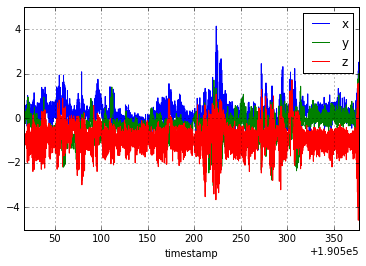

In [11]:
a_df.plot(x="timestamp", y=["x","y","z"])

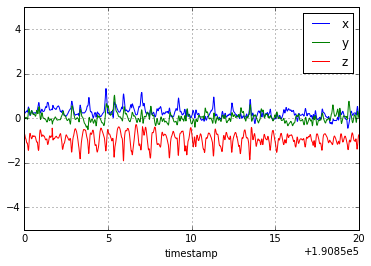

In [12]:
a_df.plot(x="timestamp", y=["x","y","z"],xlim=(190850,190870))

Use the Pythagorean theorem to calculate the magnitude of the acceleration vector of each sample from the accelerometer. Low-pass filter the magnitude signal to remove high frequency noise and then look for peaks and valleys in the filtered signal. You may need to add additional requirements to remove false positives. This is by far the simplest way to detect steps, it is also the way that most if not all ordinary pedometers of the sort that you can buy from a sports store work.

https://stackoverflow.com/questions/20324356/how-to-calculate-exact-foot-step-count-using-accelerometer-in-android

(190517.13151516672, 190577.13151516672)

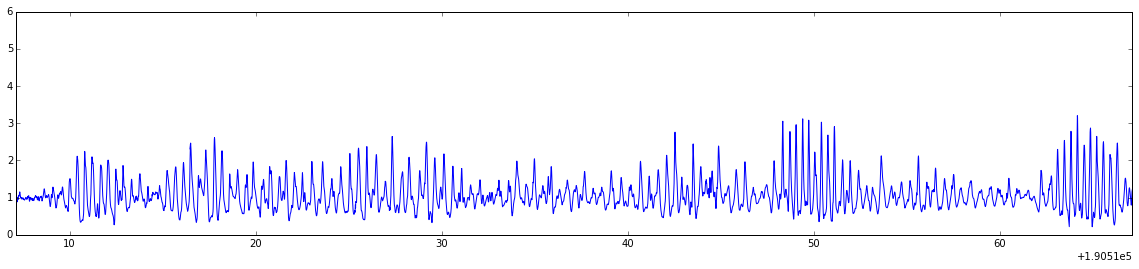

In [13]:
fig, ax = plt.subplots(figsize=(20,4))

mag = np.sqrt(a_df.x**2 + a_df.y**2 + a_df.z**2)
ax.plot(a_df.timestamp.values, mag)
start = a_df.timestamp.values.min()
ax.set_xlim(start,start+60)

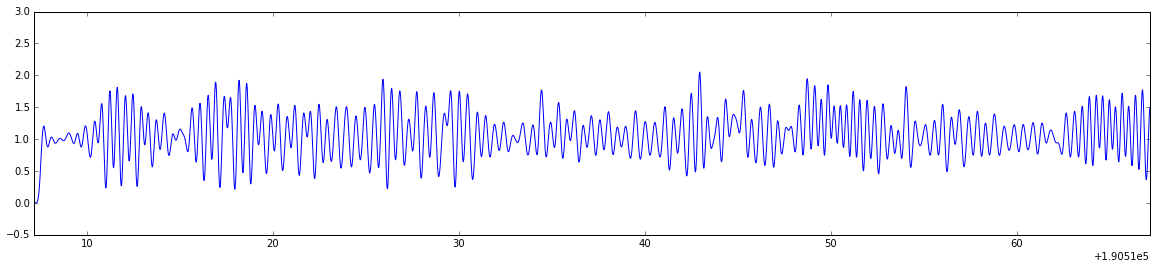

In [14]:
# Filter the data and plot
order = 9
fs = 99.0       # sample rate, Hz
cutoff = 2.667  # desired cutoff frequency of the filter, Hz

y = butter_lowpass_filter(mag, cutoff, fs, order)
fig, ax = plt.subplots(figsize=(20,4))
start = a_df.timestamp.values.min()
ax.set_xlim(start,start+60)
ax.plot(a_df.timestamp.values,y)

In [101]:
#find peaks
import peakutils

indices = peakutils.indexes(y, thres=0.02/max(y), min_dist=0.1)
peaks_x = peakutils.interpolate(a_df.timestamp.values, y, ind=indices)

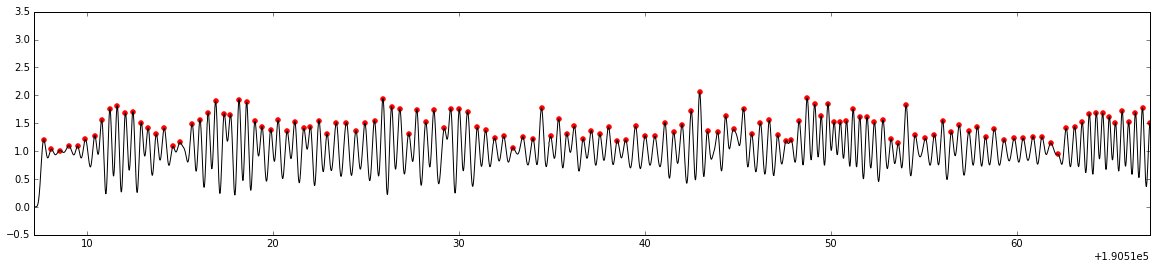

In [102]:
fig, ax = plt.subplots(figsize=(20,4))
start = a_df.timestamp.values.min()
ax.set_xlim(start,start+60)
ax.plot(a_df.timestamp.values,y, color="k")
ax.scatter(a_df.timestamp.values[indices],y[indices], color="red")

In [103]:
start_a_time = a_df.timestamp.values.min()
a_range = a_df.timestamp.values.max()-a_df.timestamp.values.min()
start_a_time, a_range

(190517.13151516672, 360.0009774583159)

In [131]:
arr_accel_steps = []
arr_hk_steps = []
arr_hk_dist = []

for index, row in ped_df.iterrows():
    delta_s = (row.endDate - row.startDate).total_seconds()
    accel_steps = np.sum(peaks_x < start_a_time + delta_s)
    arr_accel_steps.append(accel_steps)
    arr_hk_steps.append(row.numberOfSteps)
    arr_hk_dist.append(row.distance)
    print  delta_s, accel_steps, row.numberOfSteps, row.distance

 7.0 15 13 10.01
10.0 22 18 13.81
13.0 29 24 18.55
15.0 34 29 21.5251861091
18.0 40 35 23.9971503591
20.0 44 41 25.2998297509
23.0 51 46 27.1289743637
26.0 57 52 31.0561626799
28.0 61 57 31.8568246995
31.0 68 63 34.702559189
33.0 72 68 38.0822843743
36.0 78 72 40.0822041471
39.0 84 78 43.7872271837
41.0 89 82 46.444762827
44.0 97 88 51.4847628269
46.0 102 92 54.8447628269
49.0 109 98 59.1647628269
51.0 113 104 63.3047628269
54.0 119 109 66.8547628269
57.0 126 113 69.5747628269
59.0 132 118 73.6747628269
62.0 139 124 78.6547628269
64.0 145 129 82.6547628269
67.0 153 133 86.1747628269
70.0 159 139 90.4347628269
72.0 163 139 90.4347628269
75.0 170 144 94.1347628269
77.0 174 148 97.1347628269
80.0 180 153 98.1692975172
82.0 185 159 102.547070195
85.0 191 164 104.8288664
88.0 198 170 106.504038473
90.0 202 176 109.745667401
93.0 208 181 110.838001965
95.0 212 187 113.791667129
98.0 219 192 117.303729269
101.0 224 192 117.303729269
103.0 228 196 119.008385251
106.0 235 202 123.436551993
108.

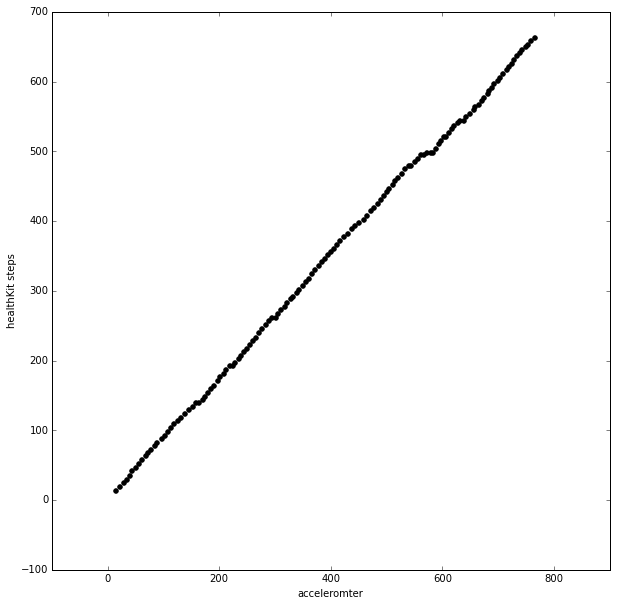

In [135]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(arr_accel_steps,arr_hk_steps, color="k")
ax.set_xlabel('acceleromter')
ax.set_ylabel('healthKit steps')

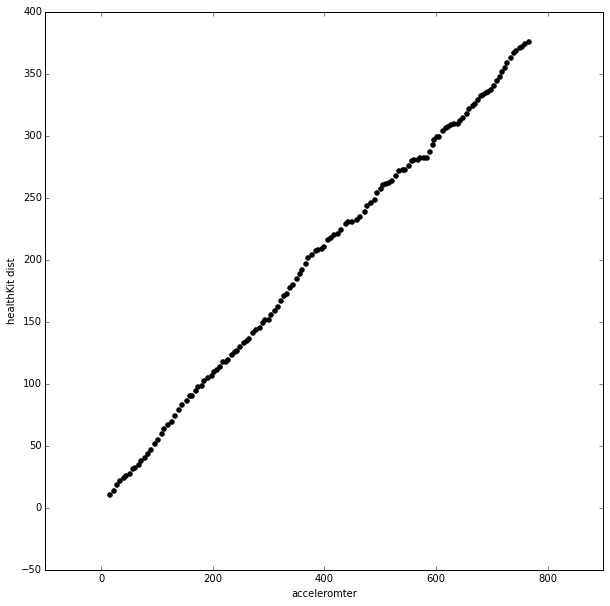

In [136]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(arr_accel_steps,arr_hk_dist, color="k")
ax.set_xlabel('acceleromter')
ax.set_ylabel('healthKit dist')

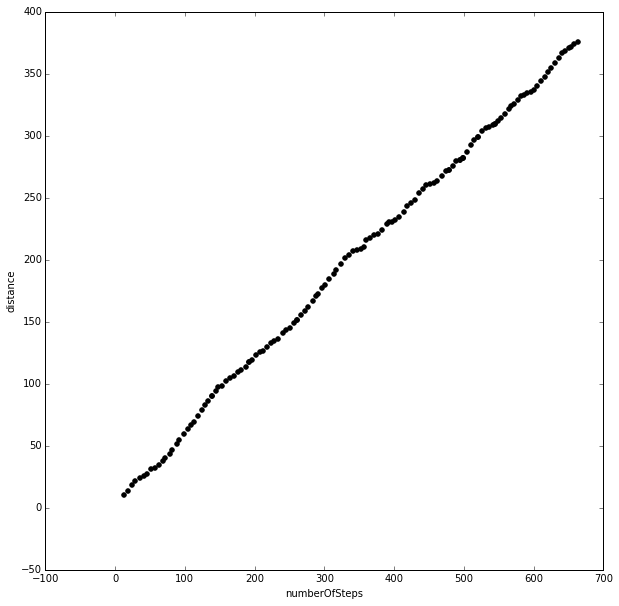

In [133]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(ped_df.numberOfSteps ,ped_df.distance , color="k")
ax.set_xlabel('numberOfSteps')
ax.set_ylabel('distance')

In [109]:
# 6mwt - displacement data

columns = ( (-1, "UnknownFile_1.json.items"),)
base_path="/Users/hershman/Amazon Drive/Stanford/data/MHC/6mwt-displacement"
table_fn = "6mwt.csv"

disp_df = DownloadTableColumns(syn, table_id = 'syn4214144', columns = columns, 
              base_path=base_path, table_fn = table_fn)

Ending at limit 50


In [110]:
disp_df

,UnknownFile_1.json.items,appVersion,createdOn,createdOnTimeZone,dataGroups,externalId,healthCode,phoneInfo,recordId,uploadDate,userSharingScope
0,16640512,"version 2.0.1, build 3",2017-07-10 23:28:33,-1000,None,None,4d6f1e86-9864-4a04-865e-123847613972,"iPhone9,4",12cfe78d-fdbb-48f5-af96-d08a7ceb4425,2017-07-11,SPONSORS_AND_PARTNERS
1,16641072,"version 2.0.1, build 3",2017-07-10 12:25:59,-0400,None,None,0abfad79-cb33-4c1c-8531-64643381af55,"iPhone8,4",e251bd74-bd6e-424e-a245-07194cbf0edb,2017-07-11,ALL_QUALIFIED_RESEARCHERS
2,16641335,"version 2.0.1, build 3",2017-07-10 15:02:18,-0400,None,None,0661c8f7-818e-44f7-9fe8-e23e074e44fb,iPhone 6,bd2dddda-ff04-4e48-8318-ad176f5dec03,2017-07-11,ALL_QUALIFIED_RESEARCHERS
3,16641770,"version 2.0.1, build 3",2017-07-11 05:10:09,-0700,None,None,272d255e-55fa-4ddb-827a-e8735b19866e,"iPhone9,2",9646bd67-be0b-4c46-9fd9-0500e7e8ee6a,2017-07-11,SPONSORS_AND_PARTNERS
4,16641782,"version 2.0.1, build 3",2017-07-10 13:16:43,-0400,None,None,d502ee4e-0290-4ae9-8050-d376727d8b33,"iPhone8,2",b0586f88-8f59-4771-b134-cb59dd9afbc7,2017-07-11,ALL_QUALIFIED_RESEARCHERS
5,16641874,"version 2.0.1, build 3",2017-07-10 12:22:03,-0500,None,None,893fe61e-637a-47a9-83f1-50e80f9b9308,iPhone 6,8025067a-34bf-448d-87c3-5d61a77ed8de,2017-07-11,ALL_QUALIFIED_RESEARCHERS
6,16634104,"version 2.0.1, build 3",2017-07-09 12:00:48,+0100,None,None,a82ddd55-b985-4043-a8f5-b3c2eda459fd,"iPhone8,1",555e2670-18b8-4bba-aefa-c85a3f7c684d,2017-07-10,ALL_QUALIFIED_RESEARCHERS
7,16634141,"version 2.0.1, build 3",2017-07-09 22:37:44,-0700,None,None,272d255e-55fa-4ddb-827a-e8735b19866e,"iPhone9,2",d30d4590-b87f-47f7-ae2c-2899ed127d64,2017-07-10,SPONSORS_AND_PARTNERS
8,16634860,"version 2.0.1, build 3",2017-07-10 02:15:53,-0700,None,None,cf17607b-02db-450d-aea8-5d7209a28bc0,"iPhone9,3",b9039cfd-1a0d-4121-8ebd-dde64ec2ad27,2017-07-10,ALL_QUALIFIED_RESEARCHERS
9,16634888,"version 2.0.1, build 3",2017-07-09 21:27:57,-0500,None,None,9776eb63-a674-4c13-ba0d-d8c78e9b5736,iPhone 6,603e043a-1f61-4bfe-af63-c812386ea96a,2017-07-10,ALL_QUALIFIED_RESEARCHERS


In [116]:
file_num = int(disp_df[disp_df.createdOn == test_row.createdOn]["UnknownFile_1.json.items"].values[0])
data_fn = '%s/%s/%d' % (base_path, "UnknownFile_1.json.items", file_num)

In [117]:
data_fn

'/Users/hershman/Amazon Drive/Stanford/data/MHC/6mwt-displacement/UnknownFile_1.json.items/16641770'

In [141]:
with open(data_fn) as data_file:    
    data = json.load(data_file)
    print data['timestamp']

2017-07-10T22:07:47-0700


In [142]:
parser.parse(data['timestamp'])

datetime.datetime(2017, 7, 10, 22, 7, 47, tzinfo=tzoffset(None, -25200))

In [147]:
time = parser.parse(data['timestamp'])

In [152]:
time.utcoffset()

datetime.timedelta(-1, 61200)

In [153]:
type(ped_df.startDate.min())

pandas.tslib.Timestamp

In [154]:
ped_df.startDate.min()

Timestamp('2017-07-11 05:01:47')